# Projeto 1 - Ciência dos Dados

Nome: Nicolas Maciel Queiroga

Nome: Francisco Pinheiro Janela

**Atenção:** Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from emoji import UNICODE_EMOJI

**Em `filename`, coloque o nome do seu arquivo de dados!**

In [2]:
import os

filename = 'Nintendo Switch.xlsx'
if filename in os.listdir():
    print(f'Encontrei o arquivo {filename}, tudo certo para prosseguir com a prova!')
else:
    print(f'Não encontrei o arquivo {filename} aqui no diretório {os.getcwd()}, será que você não baixou o arquivo?')

Encontrei o arquivo Nintendo Switch.xlsx, tudo certo para prosseguir com a prova!


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [3]:
Treinamento = pd.read_excel(filename)

# Leitura do número de relevantes e irrelevantes:
Treinamento_relevante = Treinamento[Treinamento.Relevância==1]
Treinamento_irrelevante = Treinamento[Treinamento.Relevância==0]
print('Número de relevantes: {0}\nNúmero de irrelevantes: {1}'.format(len(Treinamento_relevante),len(Treinamento_irrelevante)))

#Treinamento.head()  # debug

Número de relevantes: 106
Número de irrelevantes: 194


In [4]:
Teste = pd.read_excel(filename, sheet_name = 'Teste')

# Leitura do número de relevantes e irrelevantes:
Teste_relevante = Teste[Teste.Relevância==1]
Teste_irrelevante = Teste[Teste.Relevância==0]
print('Número de relevantes: {0}\nNúmero de irrelevantes: {1}'.format(len(Teste_relevante),len(Teste_irrelevante)))


#Teste.head(5)  # debug

Número de relevantes: 32
Número de irrelevantes: 87


___
## Classificador automático de sentimento


### Descrição do Produto:

O produto escolhido foi um console de videogames lançado em Março de 2017, que propôs uma integração entre console fixo e portátil, o primeiro do mercado em sua categoria.

### Decisão para classificação:

Para classificar os tweets nas categorias de **relevante** e **irrelevante**, escolhemos para relevantes posts que mostrassem sentimentos do usuário, reclamações e elogio sobre o produto. Tudo que fala sobre lançamentos, patch ou sobre outros consoles foi classificado como irrelevante.

___
### Montando um Classificador Naive-Bayes

#### 1) Categorizando:

Primeiramente, os números 1 e 0 serão substituídos por suas categorias de relevante e irrelevante, respectivamente:

In [5]:
# Transformando a classe de Relevância em categorias:
Treinamento['Relevância'] = Treinamento['Relevância'].astype('category')
Teste['Relevância'] = Teste['Relevância'].astype('category')

# Trocando os valores pelas categorias correspondentes:
Treinamento.Relevância.cat.categories = ['Irrelevante','Relevante']
Teste.Relevância.cat.categories = ['Irrelevante','Relevante']


#Treinamento.head()  #debug

#### 2) Limpeza dos tweets:

Em seguida, vamos fazer uma limpeza no nosso excel, excluíndo sinais de pontuação e corrigindo espaços dos emojis:

In [6]:
#================================================== Limpando caracteres =======================================================

def limpeza(texto):
    pontuacao = '[!,)"(\-/.\n:?;]'
    pattern = re.compile(pontuacao)
    texto_limpo = re.sub(pattern, ' ', texto)
    return texto_limpo

#============================================== Arrumando espaços e emojis ====================================================

def is_emoji(emoji):
    return emoji in UNICODE_EMOJI

def add_espaco(texto):
    return ''.join(' ' + char if is_emoji(char) else char for char in texto).strip()


#------------------------------------------------ Aplicando nos dataframes ----------------------------------------------------
# Para o Treinamento:
resultado = [limpeza(texto) for texto in Treinamento.Treinamento]    # Aplicando a limpeza de caracteres
Treinamento.Treinamento = resultado
resultado = [add_espaco(texto) for texto in Treinamento.Treinamento] # Aplicando espaçamento entre emojis
Treinamento.Treinamento = resultado


# Para o Teste:
resultado = [limpeza(texto) for texto in Teste.Teste]    # Aplicando a limpeza de caracteres
Teste.Teste = resultado
resultado = [add_espaco(texto) for texto in Teste.Teste] # Aplicando espaçamento entre emojis
Teste.Teste = resultado


#Treinamento.head()  # debug

#### 3) Contagem de palavras:

Para fazer a probabilidade de ocorrência, vamos calcular as ocorrências absolutas das palavras:

In [7]:
#==================================================== Frases em Lista =========================================================
## Listas gerais:
Lista_Treinamento = list(Treinamento.Treinamento)
Lista_Teste = list(Teste.Teste)


## Listas de relevância para Treinamento:
# Lista Relevante:
filtro_relevante = Treinamento.loc[Treinamento.Relevância == 'Relevante',:]
Lista_Treinamento_Relevante = list(filtro_relevante.Treinamento)

# Lista Irrelevante:
filtro_irrelevante = Treinamento.loc[Treinamento.Relevância == 'Irrelevante',:]
Lista_Treinamento_Irrelevante = list(filtro_irrelevante.Treinamento)


#print(Lista_Treinamento_Relevante)  # debug


#================================================= Separando por Palavra ======================================================
## Função para separar:
def por_palavra(LISTA):
    lista_palavras = []
    for linha in LISTA:
        nova_linha = linha.split()
        for palavra in nova_linha:
            lista_palavras.append(palavra)
    return lista_palavras

#------------------------------------------------------- Aplicando ------------------------------------------------------------
## Listas por palavra:
# Listas Gerais:
Palavras_Treinamento = por_palavra(Lista_Treinamento)
Palavras_Teste = por_palavra(Lista_Teste)

## Listas de relevância para Treinamento:
Palavras_Treinamento_Relevante = por_palavra(Lista_Treinamento_Relevante)
Palavras_Treinamento_Irrelevante = por_palavra(Lista_Treinamento_Irrelevante)


#print(Palavras_Treinamento_Irrelevante)  # debug


#============================================ Guardando palavras sem repetição ================================================
## Somente para as Listas Gerais (será usado mais tarde):
# Função:
def tira_repeticao(LISTA):
    sem_repeticao = []
    for palavra in LISTA:
        if not palavra in sem_repeticao:
            sem_repeticao.append(palavra)
    return sem_repeticao

#------------------------------------------------------- Aplicando ------------------------------------------------------------
Palavras_Treinamento_SR = tira_repeticao(Palavras_Treinamento)
Palavras_Teste_SR = tira_repeticao(Palavras_Teste)


#================================================== Contagem de palavras ======================================================
# Gerando as Tabelas Relativa(TR) das listas de palavras:
TR_Treinamento = pd.Series(Palavras_Treinamento).value_counts()
TR_Treinamento_Relevante = pd.Series(Palavras_Treinamento_Relevante).value_counts()
TR_Treinamento_Irrelevante = pd.Series(Palavras_Treinamento_Irrelevante).value_counts()


#TR_Treinamento_Irrelevante.head()  # debug

#### 4) Probabilidade de ocorrência:

Agora, serão criadas as probabilidades de ocorrência das palavras em cada categoria, que serão guardadas em um dicionário onde a chave é a palavra e o item a probabilidade de ocorrência na categoria.

In [8]:
#=============================================== Probabilidade primária(PP) ===================================================
## Probabilidade da mensagem ser relevante ou irrelevante com base no treinamento:
PP_Treinamento_Relevante = len(Treinamento_relevante)/len(Treinamento)
PP_Treinamento_Irrelevante = len(Treinamento_irrelevante)/len(Treinamento)


#===================================== Dicionário de Probabilidade de ocorrência(DP) ==========================================
## Aplicando o smothing de Laplace de índice 1:
Laplace = 1

## Função de cálculo da probabilidade:
def probabilidade_ocorrencia(TABELA,PALAVRAS):
    
    # Transforando a tabela de ocorrências em um dicionário
    dicionario_ocorrencias = {}
    for palavra, ocorrencia in TABELA.items():
        dicionario_ocorrencias[palavra] = ocorrencia
       
    # Criando o dicionário de probabilidades(DP):
    dicionario_probabilidades = {}
    for palavra in Palavras_Treinamento_SR:
        if palavra in PALAVRAS:
            probabilidade = (dicionario_ocorrencias[palavra]+Laplace)/(len(Palavras_Treinamento_SR)+(Laplace*len(TABELA)))
            dicionario_probabilidades[palavra] = probabilidade
        else:
            probabilidade = Laplace/(len(Palavras_Treinamento_SR)+(Laplace*len(TABELA)))
            dicionario_probabilidades[palavra] = probabilidade
    return dicionario_probabilidades


#------------------------------------------------------- Aplicando ------------------------------------------------------------
DP_Treinamento_Relevante = probabilidade_ocorrencia(TR_Treinamento_Relevante, Palavras_Treinamento_Relevante)
DP_Treinamento_Irrelevante = probabilidade_ocorrencia(TR_Treinamento_Irrelevante, Palavras_Treinamento_Irrelevante)

#print(DP_Treinamento_Relevante)  # debug

#### 5) Função do Classificador Naive Bayes:

Com o dicionário de probabilidades criado, podemos criar o classificador Naive Bayes para análise dos Tweets:

In [9]:
#=============================================== Classificador Naive Bayes ====================================================
## O classificador vai receber um Excel com os tweets numa coluna chamada Teste:
def classificador_Naive_Bayes(EXCEL):
    LISTA = list(EXCEL.Teste)
    for tweet in LISTA:
        # começa com a probabilidade do tweet ser Relevante ou Irrelevante
        probabilidade_relevante = PP_Treinamento_Relevante
        probabilidade_irrelevante = PP_Treinamento_Irrelevante
        # para a probabilidade de cada palavra do tweet nas categorias e aplicando Laplace:
        for palavra in tweet.split():
            if palavra in Palavras_Treinamento_SR:
                probabilidade_relevante *= DP_Treinamento_Relevante[palavra]
                probabilidade_irrelevante *= DP_Treinamento_Irrelevante[palavra]
            else:
                probabilidade_relevante *= Laplace/(len(Palavras_Treinamento_SR)+(Laplace*len(TR_Treinamento_Relevante)))
                probabilidade_irrelevante *= Laplace/(len(Palavras_Treinamento_SR)+(Laplace*len(TR_Treinamento_Irrelevante)))
            
        if(probabilidade_relevante > probabilidade_irrelevante):
            EXCEL.loc[(EXCEL.Teste == tweet), 'Análise'] = 'Relevante'
            ## debug
            #print('relevante: {0},  irrelevante{1}, RELEVANTE'.format(probabilidade_relevante,probabilidade_irrelevante)) 
        elif(probabilidade_relevante < probabilidade_irrelevante):
            EXCEL.loc[(EXCEL.Teste == tweet), 'Análise'] = 'Irrelevante'
            ## debug
            #print('relevante: {0},  irrelevante{1}, IRRELEVANTE'.format(probabilidade_relevante,probabilidade_irrelevante))
            
    return EXCEL

___
### Verificando a performance do Classificador

#### 1) Aplicando o classificador no Teste:

Com o classificador montado, vamos aplicar para a planilha de Testes:

In [12]:
#----------------------------------------------- Aplicando o classificador ----------------------------------------------------

Teste_Classificado = classificador_Naive_Bayes(Teste)

Teste_relevante = Teste_Classificado[Teste.Análise=='Relevante']
Teste_irrelevante = Teste_Classificado[Teste.Análise=='Irrelevante']
print('Número de relevantes: {0}\nNúmero de irrelevantes: {1}'.format(len(Teste_relevante),len(Teste_irrelevante)))

#Teste_Classificado  # debug

Número de relevantes: 23
Número de irrelevantes: 96


#### 2) Verificando a precisão da classificação:

Com a classificação feita, vamos ver aqueles que estão corretamente classificados, colocando nas tags de **Relevante Verdadeiro**, **Relevante Falso**, **Irrelevante Verdadeiro** e **Irrelevante Falso**, ou seja, analisar o desempenho:

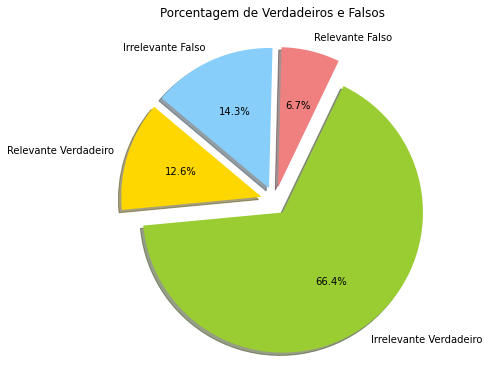

In [22]:
#============================================== Validação da Classificação ====================================================
## função para validar:
def validacao(EXCEL_Classificado):
    validado = []
    for i in range(len(EXCEL_Classificado)):
        verifica = False
        if EXCEL_Classificado.Relevância[i] == EXCEL_Classificado.Análise[i]:
            verifica = True
        validado.append(verifica)
    EXCEL_Classificado['Validação'] = validado
    return EXCEL_Classificado
        
    
#------------------------------------------------------- Aplicando ------------------------------------------------------------
## Validando a classificação:
Teste_Validado = validacao(Teste_Classificado)


#Teste_Validado  # debug

#============================================== Desempenho do Classificador ===================================================
## função para mostrar o desempenho e guarda em um Dicinário de Desempenho(DD) com as tags:
def desempenho(EXCEL_Validado):
    
    dicionario_desempenho = {}
    Contagem_Relevante_Verdadeiro = 0
    Contagem_Irrelevante_Verdadeiro = 0
    Contagem_Relevante_Falso = 0
    Contagem_Irrelevante_Falso = 0
    
    for i in range(len(EXCEL_Validado)):
        if EXCEL_Validado.Validação[i] == True:
            if EXCEL_Validado.Análise[i] == 'Relevante':
                Contagem_Relevante_Verdadeiro += 1
            else:
                Contagem_Irrelevante_Verdadeiro += 1
        else:
            if EXCEL_Validado.Análise[i] == 'Relevante':
                Contagem_Relevante_Falso += 1
            else:
                Contagem_Irrelevante_Falso += 1
    
    Porcentagem_RV = Contagem_Relevante_Verdadeiro/len(EXCEL_Validado)
    Porcentagem_IV = Contagem_Irrelevante_Verdadeiro/len(EXCEL_Validado)
    Porcentagem_RF = Contagem_Relevante_Falso/len(EXCEL_Validado)
    Porcentagem_IF = Contagem_Irrelevante_Falso/len(EXCEL_Validado)
    
    dicionario_desempenho['Relevante Verdadeiro'] = Porcentagem_RV
    dicionario_desempenho['Irrelevante Verdadeiro'] = Porcentagem_IV
    dicionario_desempenho['Relevante Falso'] = Porcentagem_RF
    dicionario_desempenho['Irrelevante Falso'] = Porcentagem_IF
    
    return dicionario_desempenho
            

#------------------------------------------------------- Aplicando ------------------------------------------------------------
## aplicando a função para gerar o desempenho do classificador baseado no Teste:
DD_Teste = desempenho(Teste_Validado)


#print(DD_Teste)  # debug


#----------------------------------------------------- Em um gráfico ----------------------------------------------------------
## função para plotar o gráfico: 
def DD_grafico(DD):
    # processando a informação do gráfico
    labels = 'Relevante Verdadeiro', "Irrelevante Verdadeiro", "Relevante Falso", 'Irrelevante Falso'
    sizes = [DD['Relevante Verdadeiro'], DD["Irrelevante Verdadeiro"], DD["Relevante Falso"], DD['Irrelevante Falso']]
    colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
    
    # plotando o gráfico
    plt.figure(figsize=[6,6])
    plt.pie(sizes, explode=(0.1, 0.1, 0.1, 0.1), labels=labels, colors=colors,
    autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.title("Porcentagem de Verdadeiros e Falsos\n")
    plt.show()
    
## Gerando o gráfico para nosso Dicionário de Desempenho:
DD_grafico(DD_Teste)

___
### Concluindo

Baseado no gráfico acima, os resultados obtidos pelo classificador são satisfatórios para sua primeira iteração. Ele avaliou corretamente 79% dos tweets da planilha de teste. Para questões semânticas, como duplas negações e sarcasmos, o classificador não as leva em consideração, por se basear em análise quantitativa de palavras, sendo uma das melhorias que poderiam ser aplicadas ao classificador para realizar sua decisão. A empresa deve continuar investindo em nosso serviço, pois é possível iterar o classificador e produzir análises mais coerentes com a realidade da relevância dos tweets, sendo uma questão de tempo até que o indice de acerto melhore consideravelmente e assegure as necessidades de classificação.

#### 1) Outras Limpezas e Transformações:

Para alcançar esse ideal de classificador exigido pelas empresas, seriam necessárias outras limpezas e transformações ao Dataframe de Tweets. Essas limpezas produzem uma base para classificação mais acertiva, pois enibem vieses que levam a uma má classificação. Entre essas limpezas e transformações estão:

- Excluir Stop Words, como preposições, conjunções e artigos;
- Transformar verbos para o infinitivo e substantivos e adjetivos para o singular;
- Excluir links e anexos;
- Excluir tags de 'rt' e @ de usuários;
- Interpretar linguagens de sentimento, como 'kkkkkkk' = 'hahahahahaha' = risada;
- Corrigir vícios de abreviação da escrita online, como 'vc' = você, 'mds' = meu Deus.

#### 2) O Classificador não serve para aumentar a base de Treinamento:

O Classificador de Naive Bayes não deve ser usado para ampliar a base de treinamento, uma vez que ao fazer crescer essa base criará um vício de classificação que não permitirá que Tweets mais recentes que sejam relevantes mas não classificados antes como tal sejam recebidos pela empresa e rapidamente rejeitados. Esse viés na ampliação da base de treinamento deixa ela maior, porém não mais completa, pois não comporta outros estilos de comentários relevantes.

#### 3) Outros cenários para aplicação de Naive Bayes:

O sistema para classificação de textos é muito importante e usado para analisar Spam. Essa análise é feita em e-mails, posts e comentários das redes sociais para tornar a experiência do usuário mais agradável, não incomodando-o com coisas que não são de seu interesse.

Serve também para criar um feed de informação que seja coerente com as pesquisas e preferências do usuário, pois têm um padrão sendo necessário treinar o classificador para poder aplicar o filtro desejado.

Em geral, Naive Bayes pode ser utilizado para qualquer tipo de Data Mining desejado por seu criador ou pedido por seu usuário, sendo somente necessária uma base de treinamento para o Classificador.

___
## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis
* Corrigir separação de espaços entre palavras e emojis ou entre emojis e emojis
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B)
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* Montar um dashboard que realiza análise de sentimento e visualiza estes dados

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**